# Image Captioning Part I
> Learn how to prepare a dataset and perform feature extraction for later training an Image Captioning model

- toc: true
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, vision, captioning]

In order to build an image captioning model, we need to transform the data and extract features that can be used as input for such model. We need to encode the images into a dense representation as well as encode the text as embeddings (vectorial representations of sentences).

This article, will focus on building this feature extractor and apply to generate a formatted features for the image captioning model trainig.

We will use the Flickr8k dataset (availble on Kaggle [here](https://www.kaggle.com/adityajn105/flickr8k)). So we wil install Kaggle CLI and download the dataset.

In [2]:
%%capture
%%bash

pip install kaggle --upgrade

mkdir -p ~/.kaggle
echo '{"username":"KAGGLE_USER","key":"KAGGLE_KEY"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [3]:
%%capture
%%bash

kaggle datasets download adityajn105/flickr8k
mkdir -p flickr8k
unzip flickr8k.zip -d flickr8k

 98% 1.02G/1.04G [00:16<00:00, 51.2MB/s]
100% 1.04G/1.04G [00:16<00:00, 67.7MB/s]


> Note: you need to replace `KAGGLE_USER` with your actual Kaggle username and `KAGGLE_KEY` with your API key for the download to work.
 

Import the needed dependencies

In [76]:
import glob
import os
import pathlib
from math import sqrt
from joblib import Parallel, delayed
import pickle
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

Set the following variables to the paths where the dataset is available

In [20]:
BASE_PATH = 'flickr8k'
IMAGES_PATH = f'{BASE_PATH}/Images'
CAPTIONS_PATH = f'{BASE_PATH}/captions.txt'

With the path to the images set, we can list all the image files

In [23]:
image_paths = list(glob.glob(f'{IMAGES_PATH}/*.jpg'))

Let's read the captions file into a Pandas dataframe and have look to it

In [96]:
captions_df = pd.read_csv(CAPTIONS_PATH)
captions_df = captions_df.groupby('image').first().reset_index()
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


> Note: in the dataset each image has more than one caption, we discard all captions and keep only one per image for simplicity

With the images and captions loaded, we can take a random sample and dispaly some images with their respective caption

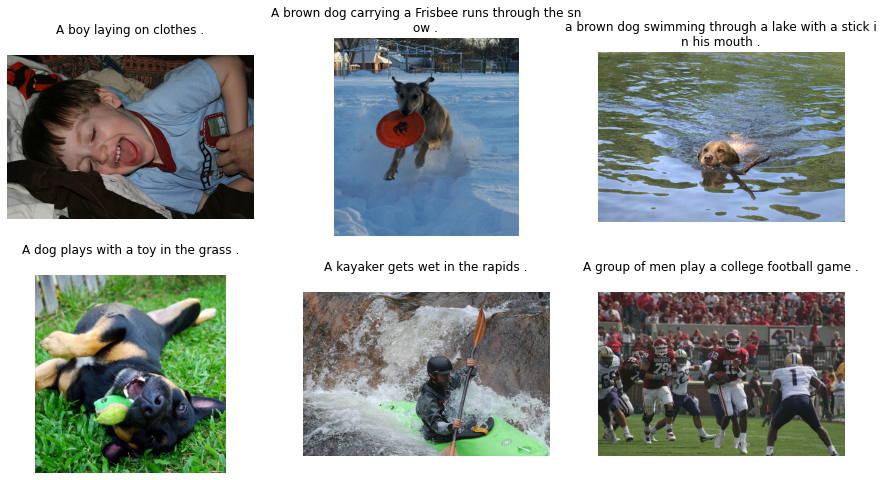

In [97]:
samples = captions_df.sample(6).reset_index()
figure, axis = plt.subplots(2, 3, figsize=(15, 8))
for index, sample in samples.iterrows():
    image = plt.imread(f'{IMAGES_PATH}/{sample["image"]}')
    title = sample['caption'][:50] + '\n' + sample['caption'][50:]
    row, col = int(index / 3), index % 3
    axis[row, col].imshow(image)
    axis[row, col].set_title(title)
    axis[row, col].axis('off')

We need to clean the text in captions (e.g. removing punctuation) to simplify training, and also adding special tokens `start_token` to be added at the begning of the text, and `end_token` added at the end.

In [93]:
def clean_caption(caption, start_token='_sos_', end_token='_eos_'):
    def remove_punctuation(word):
        translation = str.maketrans('', '', punctuation)
        return word.translate(translation)
    def is_valid_word(word):
        return len(word) > 1 and word.isalpha()
    caption = caption.lower().split(' ')
    caption = map(remove_punctuation, caption)
    caption = filter(is_valid_word, caption)
    cleaned_caption = f'{start_token} {" ".join(caption)} {end_token}'
    return cleaned_caption

In [94]:
captions_df['caption'] = captions_df.caption.apply(lambda x: clean_caption(x))

We will need to perform padding later, hence we need to determine the maximum caption text length

In [86]:
max_seq_len = captions_df.caption.apply(lambda x: len(x)).max()

We take the captions into an array that should be of same length as the image paths array

In [73]:
captions = captions_df.caption.values

8091

In [74]:
len(image_paths), len(captions)

(8091, 8091)

As we have lot images, we will use joblib to parallelize the processing of those files. To also keep track of the processing pragress we define the following class that wraps `joblib.Parallel`

In [48]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

The following class groups the different feautre extraction steps that loads VGG16 trained on ImageNet to be used for transforming images into a vector, also it will sequences out of the image's caption.

In [55]:
class FeatureExtractor(object):
    def __init__(self, output_path, max_seq_len):
        self.feature_extractor = VGG16(input_tensor=Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
        self.output_path = output_path
        self.tokenizer = Tokenizer()
        self.max_seq_length = max_seq_len

    def create_image_vector(self, path):
        """Create a vector representing the image"""
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        return self.feature_extractor.predict(image)[0]

    def create_mapping(self, paths, captions):
        """Extract features from each image, and create mapping from image filename to image features and caption"""
        mapping = {}
        print('\nExtracting features...')
        def extract_feature(path, caption):
            features = self.create_image_vector(path)
            image_id = pathlib.Path(path).stem
            mapping[image_id] = {'features': features, 'caption': caption}
        job = ProgressParallel(n_jobs=10, prefer="threads", total=len(paths))
        job(delayed(extract_feature)(paths[i], captions[i]) for i in range(len(paths)))
        return mapping

    def save_mapping(self, mapping):
        """Save mappings into disk"""
        out_path = f'{self.output_path}/mapping.pickle'
        with open(out_path, 'wb') as f:
            pickle.dump(mapping, f, protocol=4)

    def extract_features(self, paths, captions):
        """Extract features from images and captions and stores them to disk"""
        self.tokenizer.fit_on_texts(captions)
        mapping = self.create_mapping(paths, captions)
        self.save_mapping(mapping)
        in_feats, in_seqs, out_seqs = self.create_sequences(mapping)
        self.save_sequences(in_feats, in_seqs, out_seqs)

    def create_sequences(self, mapping):
        """Create sequences based on the image and its caption"""
        num_classes = len(self.tokenizer.word_index) + 1
        in_feats = []
        in_seqs = []
        out_seqs = []
        print('\nCreating sequences...')
        for _, data in tqdm(mapping.items()):
            feature = data['features']
            caption = data['caption']
            seq = self.tokenizer.texts_to_sequences([caption])
            seq = seq[0]
            # create as many sequences as the length of the current caption
            for i in range(1, len(seq)):
                # input sequence is first ith characters
                input_seq = seq[:i]
                input_seq, = pad_sequences([input_seq], self.max_seq_length)
                # output sequence is the next character which is the ith  
                out_seq = seq[i]
                out_seq = to_categorical([out_seq], num_classes)[0]
                # add all to lists
                in_feats.append(feature)
                in_seqs.append(input_seq)
                out_seqs.append(out_seq)
        return in_feats, in_seqs, out_seqs

    def save_sequences(self, in_feats, in_seqs, out_seqs):
        """Save image features, input and output sequences into disk"""
        filenames = ['input_features.pickle', 'input_sequences.pickle', 'output_sequences.pickle']
        sequences = [in_feats, in_seqs, out_seqs]
        for filename, seq in zip(filenames, sequences):
            with open(f'{self.output_path}/{filename}', 'wb') as f:
                pickle.dump(np.array(seq), f, protocol=4)



Now we can create an instance of the feature extractor and run it on the images and their captions

In [56]:
extractor = FeatureExtractor('.', max_seq_len)

In [58]:
extractor.extract_features(image_paths, captions)


Extracting features...


100%|██████████| 8091/8091 [1:03:30<00:00,  2.12it/s]



Creating sequences...


100%|██████████| 8091/8091 [00:00<00:00, 69189.88it/s]


As the dataset have lot images, it may take some time before it finishes. At the end, it will generate the following pickle files:
- `mapping.pickle`
- `input_features.pickle`
- `input_sequences.pickle`
- `output_sequences.pickle`


Next we will use those files as input for training an Image Captioning model.